In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Import uuid library to generate unique image names
import uuid

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

In [6]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [7]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [8]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [9]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [10]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [11]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [12]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [13]:
inp = Input(shape=(100,100,3), name='input_image')


In [14]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)


In [15]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)


In [16]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)


In [17]:
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)


In [18]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)


In [19]:
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)


In [20]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)


In [21]:
f1 = Flatten()(c4)


In [22]:
d1 = Dense(4096, activation='sigmoid')(f1)


In [23]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')


In [24]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
embedding = make_embedding()

In [26]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, input_embedding, validation_embedding):
        # Convert inputs to tensors if they are not already
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        # Calculate the absolute difference
        return tf.math.abs(input_embedding - validation_embedding)


In [28]:
l1 = L1Dist()

In [29]:
input_image = Input(name='input_img', shape=(100,100,3))


In [30]:
validation_image = Input(name='validation_img', shape=(100,100,3))

In [31]:
inp_embedding = embedding(input_image)


In [32]:
val_embedding = embedding(validation_image)

In [33]:
siamese_layer = L1Dist()

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

input_tensor = Input(shape=(4096,))
validation_tensor = Input(shape=(4096,))

distance = L1Dist()(input_tensor, validation_tensor)

model = Model(inputs=[input_tensor, validation_tensor], outputs=distance)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
distance = L1Dist()(input_tensor, validation_tensor)




In [36]:
classifier = Dense(1, activation='sigmoid')(distance)


In [37]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_24>

In [38]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [39]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (None, 4096)      │          0 │ input_layer[0][0… │
│                     │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [54]:

binary_cross_loss = tf.losses.BinaryCrossentropy()

In [42]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [45]:
siamese_model = make_siamese_model()

In [46]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [47]:
test_batch = train_data.as_numpy_iterator()

In [48]:
batch_1 = test_batch.next()

In [49]:
X = batch_1[:2]


In [50]:
y = batch_1[2]


In [51]:
yhat = siamese_model(X, training=True)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(16, 100, 100, 3))
  warnings.warn(msg)


In [52]:
y = tf.reshape(y, yhat.shape)

In [53]:
y

<tf.Tensor: shape=(1, 16, 1), dtype=float32, numpy=
array([[[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.]]], dtype=float32)>

In [55]:
@tf.function
def train_step(batch):
    # Record all operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        tf.print("Before reshape:", "y shape:", y.shape, "yhat shape:", yhat.shape)

        # Align shapes
        yhat = tf.squeeze(yhat, axis=[0, 2])  # Remove extra dimensions
        tf.print("After reshape:", "y shape:", y.shape, "yhat shape:", yhat.shape)

        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        tf.print("Loss:", loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Apply gradients
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss



In [56]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [57]:
EPOCHS = 50

In [58]:
train(train_data, EPOCHS)


 Epoch 1/50
Before reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])
Loss: 0.693616152
 1/27 ━━━━━━━━━━━━━━━━━━━━ 32:14 74s/stepBefore reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])
Loss: 0.679962277
 2/27 ━━━━━━━━━━━━━━━━━━━━ 29:45 71s/stepBefore reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])
Loss: 0.668015
 3/27 ━━━━━━━━━━━━━━━━━━━━ 28:29 71s/stepBefore reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])
Loss: 0.540127754
 4/27 ━━━━━━━━━━━━━━━━━━━━ 27:04 71s/stepBefore reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_image']
Received: inputs=Tensor(shape=(4, 100, 100, 3))
  warnings.warn(msg)


Before reshape: y shape: TensorShape([4]) yhat shape: TensorShape([1, 4, 1])
After reshape: y shape: TensorShape([4]) yhat shape: TensorShape([4])
Loss: 0.00697350595
27/27 ━━━━━━━━━━━━━━━━━━━━ 1840s 68s/step

 Epoch 2/50
Before reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])
Loss: 0.479149759
 1/27 ━━━━━━━━━━━━━━━━━━━━ 29:55 69s/stepBefore reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])
Loss: 0.386332035
 2/27 ━━━━━━━━━━━━━━━━━━━━ 28:47 69s/stepBefore reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16])
Loss: 0.340204209
 3/27 ━━━━━━━━━━━━━━━━━━━━ 27:41 69s/stepBefore reshape: y shape: TensorShape([16]) yhat shape: TensorShape([1, 16, 1])
After reshape: y shape: TensorShape([16]) yhat shape: TensorShape([16

In [59]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall


In [60]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [62]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


array([[[9.9985588e-01],
        [1.0000000e+00],
        [1.5988701e-12],
        [6.6097492e-08],
        [6.8067262e-12],
        [2.0271257e-08],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9787402e-01],
        [9.9998057e-01],
        [9.9992102e-01],
        [1.0000000e+00],
        [9.9999994e-01],
        [9.9999952e-01],
        [3.7482167e-10],
        [1.0000000e+00]]], dtype=float32)

In [121]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [63]:
y_true

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [64]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

In [65]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

np.float32(1.0)

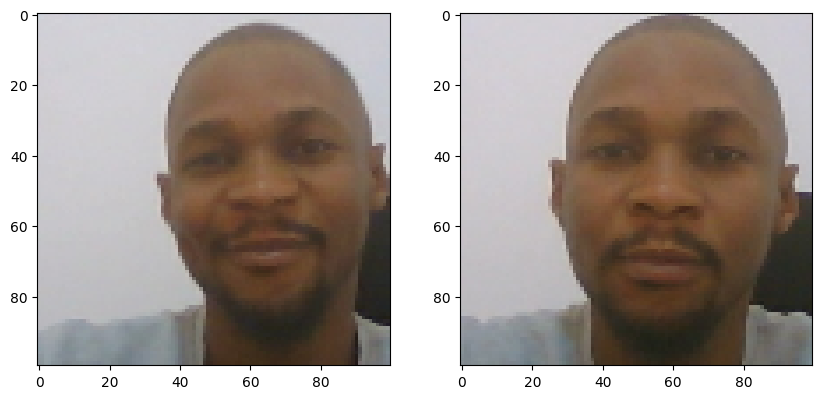

In [68]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [69]:
# Save weights
siamese_model.save('siamesemodel.h5')